Importamos librerias

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

Importamos los CSV

In [2]:
df_data=pd.read_csv("../data/data.csv")
df_train=df_data[~df_data['x_e_out [-]'].isna()]
df_test = df_data[df_data['x_e_out [-]'].isna()]
df_original=pd.read_csv("../data/original_dataset.csv")

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


In [5]:
df_data.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [6]:
df_original.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [7]:
## Descubrimos que hay una columna numérica que está completa en ambos dataset y tienen los mismos valores exactamente

In [8]:
sorted(df_original["chf_exp [MW/m2]"].unique())==sorted(df_data["chf_exp [MW/m2]"].unique())

True

In [9]:
len(df_original["chf_exp [MW/m2]"].unique())==len(df_data["chf_exp [MW/m2]"].unique())

True

# Preparar los datos

In [10]:
df_combinado=pd.concat([df_data,df_original])
df_combinado.reset_index(inplace=True,drop=True)
df_combinado.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,0,Thompson,tube,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,1,Thompson,tube,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,2,Thompson,NaN,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,3,Beus,annulus,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,4,NaN,tube,13.79,686.0,NaN,11.1,11.1,457.0,2.8


<AxesSubplot:>

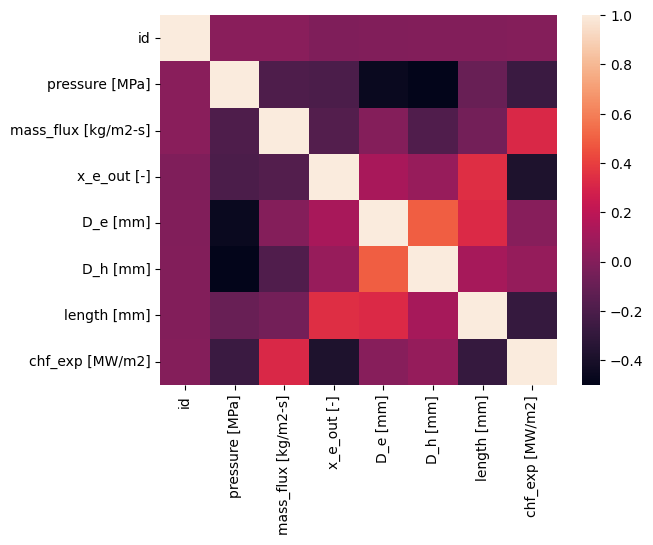

In [11]:
import seaborn as sns
sns.heatmap(df_combinado.corr())

In [12]:
numerical_columns = ['pressure [MPa]', 'mass_flux [kg/m2-s]','x_e_out [-]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
numerical_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]']
categorical_columns = ['author', 'geometry']
target = 'x_e_out [-]'

In [13]:
label_encoders = {}

def label_encode(df: pd.DataFrame) -> None:
    for column in categorical_columns:
        label_encoder: LabelEncoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
        label_encoders[column] = label_encoder

def reverse_encode(df: pd.DataFrame) -> None:
    for column in label_encoders.keys():
        df[column] = df[column].astype(int)
        df[column] = label_encoders[column].inverse_transform(df[column])

def one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    one_hot_encoded_data = pd.get_dummies(df, columns=categorical_columns)
    return one_hot_encoded_data

def normalize(df: pd.DataFrame) -> pd.DataFrame:
    for column in numerical_features:
        column_values = df[column].values  # No need to reshape column values
        not_nan_values = column_values[~pd.isnull(column_values)]  # Filter non-NaN values

        if not_nan_values.size > 0:  # Check if there are any non-NaN values
            not_nan_values = not_nan_values.reshape(-1, 1)  # Reshape to 2D array with single column
            standard_scaler = StandardScaler()
            normalized_values = standard_scaler.fit_transform(not_nan_values)

            # Create a mask to identify non-NaN values in the column
            mask = ~pd.isnull(df[column])
            df.loc[mask, column] = normalized_values.flatten()

    return df

In [14]:
df_combinado['geometry'].fillna('tube', inplace=True)
df_combinado['author'].fillna('Thompson', inplace=True)

In [15]:
df_combinado = normalize(df_combinado)
#label_encode(df_combined)
df_combinado = one_hot_encode(df_combinado)
df_combinado=df_combinado.drop(columns="id")
df_combinado

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,author_Williams,geometry_annulus,geometry_plate,geometry_tube
0,-0.830902,0.404113,0.1754,NaN,-0.175731,-0.600507,-0.100901,0,0,0,0,0,0,0,1,0,0,0,0,1
1,NaN,1.691601,-0.0416,0.306885,-0.200815,-0.112494,1.209542,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,-0.655319,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.403311,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-0.504114,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,2.822395,0,0,0,0,0,0,1,0,0,0,0,1,0
33505,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,3.326411,0,0,0,0,0,0,1,0,0,0,0,1,0
33506,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,3.528018,0,0,0,0,0,0,1,0,0,0,0,1,0
33507,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,3.578420,0,0,0,0,0,0,1,0,0,0,0,1,0


# Imputar los valores nulos que son numéricos

In [16]:
df_combinado.isna().sum()

pressure [MPa]          4452
mass_flux [kg/m2-s]     4791
x_e_out [-]            10415
D_e [mm]                5488
D_h [mm]                4589
length [mm]             4759
chf_exp [MW/m2]            0
author_Beus                0
author_Inasaka             0
author_Janssen             0
author_Kossolapov          0
author_Mortimore           0
author_Peskov              0
author_Richenderfer        0
author_Thompson            0
author_Weatherhead         0
author_Williams            0
geometry_annulus           0
geometry_plate             0
geometry_tube              0
dtype: int64

In [17]:
df_imputar_valores=df_combinado.copy()

In [18]:
#Se imputan los nulos con la media de los valores que tienen el mismo chf_exp [MW/m2]
df_imputar_valores["pressure [MPa]"].fillna(df_imputar_valores.groupby("chf_exp [MW/m2]")["pressure [MPa]"].transform("mean"), inplace=True)
df_imputar_valores["mass_flux [kg/m2-s]"].fillna(df_imputar_valores.groupby("chf_exp [MW/m2]")["mass_flux [kg/m2-s]"].transform("mean"), inplace=True)
df_imputar_valores["D_e [mm]"].fillna(df_imputar_valores.groupby("chf_exp [MW/m2]")["D_e [mm]"].transform("mean"), inplace=True)
df_imputar_valores["D_h [mm]"].fillna(df_imputar_valores.groupby("chf_exp [MW/m2]")["D_h [mm]"].transform("mean"), inplace=True)
df_imputar_valores["length [mm]"].fillna(df_imputar_valores.groupby("chf_exp [MW/m2]")["length [mm]"].transform("mean"), inplace=True)

In [43]:
a=df_imputar_valores.groupby("chf_exp [MW/m2]")["length [mm]"].transform("mean")
len(a.unique())

109

Hemos eliminado todos los nulos menos en x_e_out [-] ya que es target

In [19]:
df_imputar_valores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33509 entries, 0 to 33508
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pressure [MPa]       33509 non-null  float64
 1   mass_flux [kg/m2-s]  33509 non-null  float64
 2   x_e_out [-]          23094 non-null  float64
 3   D_e [mm]             33509 non-null  float64
 4   D_h [mm]             33509 non-null  float64
 5   length [mm]          33509 non-null  float64
 6   chf_exp [MW/m2]      33509 non-null  float64
 7   author_Beus          33509 non-null  uint8  
 8   author_Inasaka       33509 non-null  uint8  
 9   author_Janssen       33509 non-null  uint8  
 10  author_Kossolapov    33509 non-null  uint8  
 11  author_Mortimore     33509 non-null  uint8  
 12  author_Peskov        33509 non-null  uint8  
 13  author_Richenderfer  33509 non-null  uint8  
 14  author_Thompson      33509 non-null  uint8  
 15  author_Weatherhead   33509 non-null 

# Preparamos los datos para el entrenamiento

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
df_imputar_valores=df_imputar_valores.drop(columns=(["author_Williams","geometry_tube"]))
df_imputar_valores

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,geometry_annulus,geometry_plate
0,-0.830902,0.404113,0.1754,0.054272,-0.175731,-0.600507,-0.100901,0,0,0,0,0,0,0,1,0,0,0
1,-0.668103,1.691601,-0.0416,0.306885,-0.200815,-0.112494,1.209542,0,0,0,0,0,0,0,1,0,0,0
2,0.736130,-0.576615,0.0335,-0.186164,-0.331250,-0.563536,-0.655319,0,0,0,0,0,0,0,1,0,0,0
3,0.736130,0.352704,-0.0279,-0.584395,0.045006,1.916454,-0.403311,1,0,0,0,0,0,0,0,0,1,0
4,0.736130,-1.338148,NaN,0.458592,-0.160681,-0.563536,-0.504114,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33504,-2.213306,-0.878291,-0.0218,1.198165,5.302565,-1.224571,2.822395,0,0,0,0,0,0,1,0,0,0,1
33505,-2.213306,-0.878291,-0.0434,1.198165,5.302565,-1.224571,3.326411,0,0,0,0,0,0,1,0,0,0,1
33506,-2.213306,-0.595823,-0.0109,1.198165,5.302565,-1.224571,3.528018,0,0,0,0,0,0,1,0,0,0,1
33507,-2.213306,-0.595823,-0.0218,1.198165,5.302565,-1.224571,3.578420,0,0,0,0,0,0,1,0,0,0,1


In [22]:
df_train = df_imputar_valores[~df_imputar_valores[target].isna()]
df_prediccion = df_imputar_valores[df_imputar_valores[target].isna()]

X=df_train.drop(columns="x_e_out [-]")
y=df_train["x_e_out [-]"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
y_train

5980     0.0196
6638    -0.0417
16250   -0.0222
29157    0.0782
32977   -0.1386
          ...  
17899   -0.0466
31990    0.0212
8029    -0.1403
1288    -0.1341
23568    0.0839
Name: x_e_out [-], Length: 18475, dtype: float64

In [25]:
X_train.columns=["pressure","mass_flux","D_e","D_h","length","chf_exp","author_Beus","author_Inasaka","author_Janssen","author_Kossolapov","author_Mortimore","author_Peskov","author_Richenderfer","author_Thompson","author_Weatherhead","geometry_annulus","geometry_plate"]
X_test.columns=["pressure","mass_flux","D_e","D_h","length","chf_exp","author_Beus","author_Inasaka","author_Janssen","author_Kossolapov","author_Mortimore","author_Peskov","author_Richenderfer","author_Thompson","author_Weatherhead","geometry_annulus","geometry_plate"]
y_train.name="x_e_out"
y_test.name="x_e_out"

# TRAIN

### Modelo 1 _XGB_

In [26]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.0749205441573825
R^2: 0.4488898381415902
MAE: 0.05306506898318904


In [27]:
model1 = xgb.XGBRegressor(
    n_estimators=2180,
    max_depth=3,
    learning_rate=0.09999132077457139,
    objective='reg:squarederror',
    min_child_weight=9.078096864028344,
    subsample= 0.9348532992028091,
    colsample_bytree= 0.5501175270950484
)

model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.07323899646724955
R^2: 0.47335090442624994
MAE: 0.05133279262915765


author_Weatherhead: 0.1649678349494934
author_Janssen: 0.12882857024669647
chf_exp: 0.11601946502923965
geometry_annulus: 0.11486130952835083
D_h: 0.0850173681974411
pressure: 0.08474791795015335
length: 0.07499334961175919
D_e: 0.042117565870285034
author_Peskov: 0.03951525688171387
mass_flux: 0.03690621256828308
author_Kossolapov: 0.031544167548418045
author_Thompson: 0.028505269438028336
geometry_plate: 0.01751907356083393
author_Beus: 0.015106934122741222
author_Mortimore: 0.01100165769457817
author_Richenderfer: 0.00537340110167861
author_Inasaka: 0.0029746810905635357


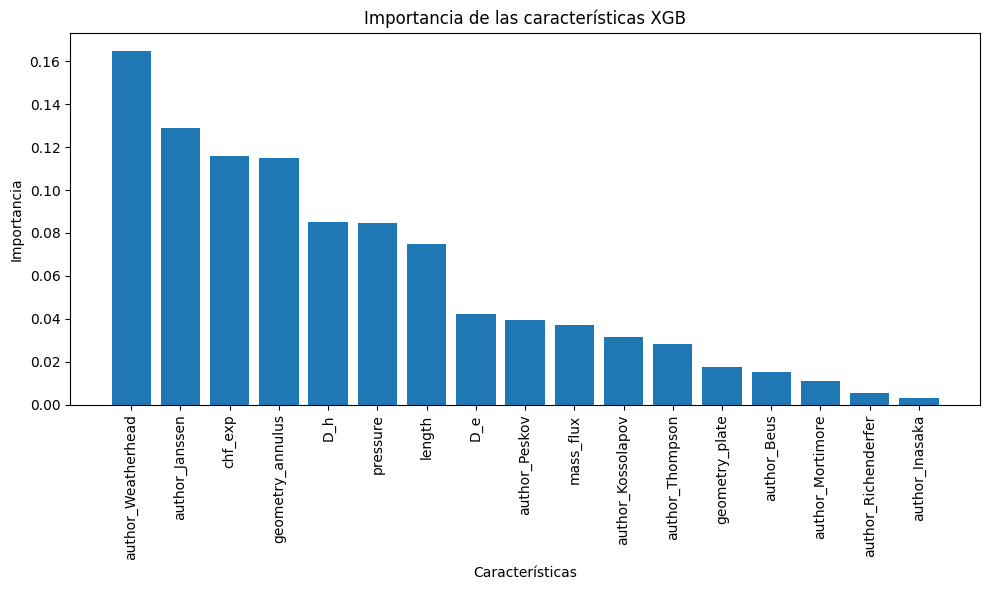

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model1.feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns

# Ordenar las importancias de mayor a menor
indices = np.argsort(importances)[::-1]

# Mostrar las importancias de las características
for i in range(len(importances)):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")

# Visualizar las importancias de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características XGB")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

### Modelo 2 _RandomForestRegressor_

In [28]:
# Crear una instancia del modelo
model2 = RandomForestRegressor(n_estimators=200, max_features="sqrt",min_samples_leaf=2,min_samples_split=10)

# Entrenar el mejor modelo con los datos de entrenamiento completos
model2.fit(X_train, y_train)

# Realizar predicciones con el mejor modelo
y_pred = model2.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.07263182620109003
R^2: 0.4820468237243878
MAE: 0.05044397835470365


chf_exp: 0.3154332227549624
pressure: 0.15265430582665449
length: 0.13929696720180101
mass_flux: 0.13017725965526522
D_h: 0.11516839357956318
D_e: 0.09710279979881008
geometry_annulus: 0.014871027953689277
author_Weatherhead: 0.011729983836384891
author_Thompson: 0.007076094043041106
author_Peskov: 0.006049810146067033
author_Janssen: 0.006008696039659105
author_Beus: 0.0019526014036688353
geometry_plate: 0.001052956235206811
author_Mortimore: 0.0004795678391829581
author_Richenderfer: 0.00045929431882143384
author_Kossolapov: 0.0003365501096733867
author_Inasaka: 0.000150469257548815


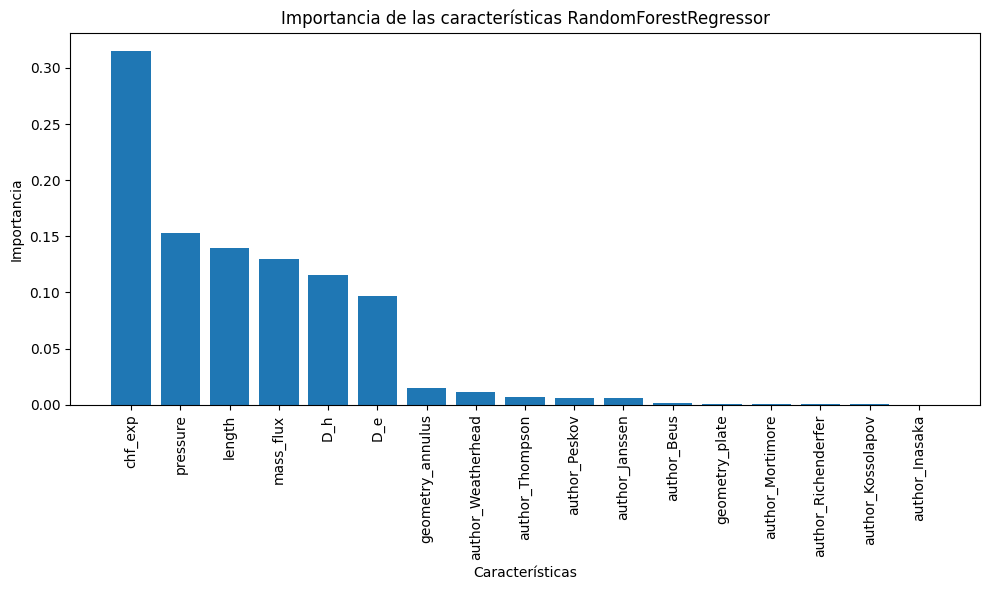

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la importancia de las características
importances = model2.feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns

# Ordenar las importancias de mayor a menor
indices = np.argsort(importances)[::-1]

# Mostrar las importancias de las características
for i in range(len(importances)):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]}")

# Visualizar las importancias de las características en un gráfico de barras
plt.figure(figsize=(10, 6))
plt.title("Importancia de las características RandomForestRegressor")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()


### Ensamble de ambos modelos con media

In [29]:
y_pred_xgb = model1.predict(X_test)
y_pred_rf = model2.predict(X_test)
y_pred_ensemble = (y_pred_xgb + y_pred_rf) / 2

In [30]:
rmse = mean_squared_error(y_test, y_pred_ensemble, squared=False)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

RMSE: 0.07223598295427455
R^2: 0.4820468237243878
MAE: 0.05044397835470365


### Ensamble de ambos modelos con media 0.7 y 0.3

In [52]:
weight_xgb = 0.3
weight_rf = 0.7

y_pred_xgb = model1.predict(X_test)
y_pred_rf = model2.predict(X_test)
y_pred_ensemble = weight_xgb * y_pred_xgb + weight_rf * y_pred_rf
rmse = mean_squared_error(y_test, y_pred_ensemble, squared=False)
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)
print("MAE:", mae)

errores=y_pred_ensemble-y_test

RMSE: 0.07222592477781122
R^2: 0.4820468237243878
MAE: 0.05044397835470365


<AxesSubplot:>

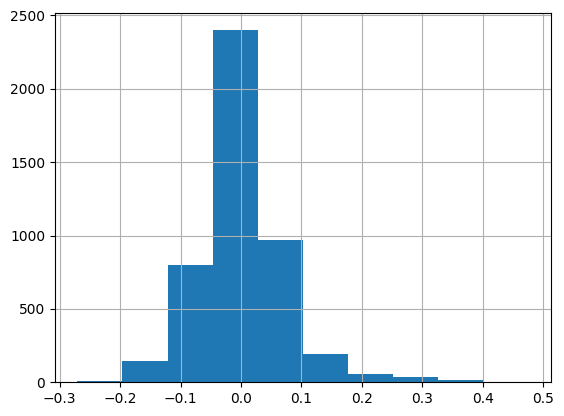

In [53]:
errores.hist()

### Pasamos la prediccion final a un CSV

In [32]:
df_prediccion=df_prediccion.drop(columns="x_e_out [-]")

In [33]:
df_prediccion.head()

,pressure [MPa],mass_flux [kg/m2-s],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2],author_Beus,author_Inasaka,author_Janssen,author_Kossolapov,author_Mortimore,author_Peskov,author_Richenderfer,author_Thompson,author_Weatherhead,geometry_annulus,geometry_plate
4,0.736130,-1.338148,0.458592,-0.160681,-0.563536,-0.504114,0,0,0,0,0,0,0,1,0,0,0
7,1.707736,-1.301992,0.249995,-0.215865,1.200702,-0.806524,0,0,0,0,0,1,0,0,0,0,0
10,0.047455,-0.024351,-1.286041,-0.622222,-1.014578,-0.302508,0,0,0,0,0,0,0,1,0,0,0
12,-0.856288,2.511322,-0.011718,-0.075396,1.614773,0.503919,0,0,0,0,0,0,0,1,0,0,0
23,1.133081,-0.960206,-0.584395,0.045006,1.916454,-0.856926,1,0,0,0,0,0,0,0,0,1,0


In [34]:
weight_xgb = 0.3
weight_rf = 0.7

y_pred_xgb = model1.predict(df_prediccion)
y_pred_rf = model2.predict(df_prediccion)
y_pred_ensemble = weight_xgb * y_pred_xgb + weight_rf * y_pred_rf

c:\Users\mgilj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- D_e [mm]
- D_h [mm]
- chf_exp [MW/m2]
- length [mm]
- mass_flux [kg/m2-s]
- ...
Feature names seen at fit time, yet now missing:
- D_e
- D_h
- chf_exp
- length
- mass_flux
- ...

  warnings.warn(message, FutureWarning)


In [35]:
index_submission=df_prediccion.index

In [36]:
df = pd.DataFrame({'id': index_submission, 'x_e_out [-]': y_pred_ensemble})
df.to_csv("../submissions/Submission5_nuevo.csv", index=False)
df

,id,x_e_out [-]
0,4,-0.003976
1,7,-0.082858
2,10,-0.053362
3,12,0.015559
4,23,0.082423
...,...,...
10410,31633,0.076079
10411,31634,-0.037516
10412,31637,0.029550
10413,31640,-0.052460
